### 實作環境
* python 3
* elasticsearch=='1.4.0' => '5.0.1'
* pyes=='0.99.4'
* es server version 2.2.0

In [15]:
def ES(addr):
    import pyes
    return pyes.ES(addr)

def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

def es_query_str(search):
    return replace_all(str(search), {"'": '"', 'True': 'true', 'False': 'false'})

conn = ES('127.0.0.1:9200')

%matplotlib inline

In [2]:
# tagg = pyes.aggs.TermsAgg('fanpage_name', 'name', size= 0) ### "size" 0 for showing all result

# qsearch = pyes.query.Search(pyes.MatchAllQuery())
# qsearch.agg.add(tagg)

# result = conn.search(query= qsearch, indices= 'facebook_nested', doc_types= 'fanpage')

# result.aggs ### 先印出所有fanpage name，再從中挑選有興趣的

In [16]:
chosen_fanpage = ["ASUS Taiwan", "Acer Taiwan", "Dell 台灣"]

### 這版pyes的terms query有minimum_match, but [terms] query does not support [minimum_match] at ES 2.2.0
qsearch = \
{
  "query": {
    "terms": {
      "name": chosen_fanpage
    }
  }
}

result = conn.search_raw(query= qsearch, indices= 'facebook_nested', doc_types= 'fanpage')

### print fanpage id, name, # of likes
for fanpage in result['hits']['hits']:
    source = fanpage['_source']
    print('id: ' + source['id'] +
          ',\tname: ' + source['name'] +
          ', \t# of likes: ' + str(source['likes_count']))

id: 177612180793,	name: ASUS Taiwan, 	# of likes: 535405
id: 204215356271305,	name: Dell 台灣, 	# of likes: 75540
id: 77322222971,	name: Acer Taiwan, 	# of likes: 104080


In [4]:
qsearch = \
{
  "query": {
    "terms": {
      "fname": chosen_fanpage
    }
  },
  "size": 0,
  "aggs": {
    "fname": {
      "terms": {
        "field": "fname"
      },
      "aggs": {
        "created_time": {
          "stats": {
            "field": "created_time"
          }
        }
      }
    }
  }
}

result = conn.search_raw(query= qsearch, indices= 'facebook_nested', doc_types= 'post')

import pandas as pd
df = []
for fanpage in result['aggregations']['fname']['buckets']:
    row = {}
    row['fanpage_name'] = fanpage['key']
    row['start_time'] = fanpage['created_time']['min_as_string']
    row['end_time'] = fanpage['created_time']['max_as_string']
    df.append(row)

df = pd.DataFrame(df)
df

,end_time,fanpage_name,start_time
0,2016-05-12T03:36:51.000Z,ASUS Taiwan,2013-01-01T04:00:00.000Z
1,2016-05-11T05:00:01.000Z,Dell 台灣,2013-01-02T13:00:02.000Z
2,2016-05-03T05:14:19.000Z,Acer Taiwan,2013-01-03T04:07:48.000Z


In [5]:
qsearch = \
{
  "query": {
    "terms": {
      "fname": chosen_fanpage
    }
  },
  "size": 0,
  "aggs": {
    "fname": {
      "terms": {
        "field": "fname"
      },
      "aggs": {
        "fid_pid": {
          "terms": {
            "field": "fid_pid",
            "size": 0
          }
        }
      }
    }
  }
}

result = conn.search_raw(query= qsearch, indices= 'facebook_nested', doc_types= 'comment')

import pandas as pd
df = []
for fanpage in result['aggregations']['fname']['buckets']:
    for post in fanpage['fid_pid']['buckets']:
        row = {}
        row['fanpage_name'] = fanpage['key']
        row['post_id'] = post['key']
        row['comments_of_post'] = post['doc_count']
        df.append(row)

df = pd.DataFrame(df)
### for next

In [6]:
def showBoxPlot(df, values, label, title, show_outliers= True):
    from bokeh.plotting import figure, show, output_file
    from bokeh.io import output_notebook

    output_notebook()

    cats = sorted(df[label].drop_duplicates().values.tolist())

    # find the quartiles and IQR for each category
    groups = df.groupby(label)
    q1 = groups.quantile(q= 0.25)
    q2 = groups.quantile(q= 0.5)
    q3 = groups.quantile(q= 0.75)
    iqr = q3 - q1
    upper = q3 + 1.5*iqr
    lower = q1 - 1.5*iqr

    # find the outliers for each category
    def outliers(group):
        cat = group.name
        return group[(group[values] > upper.loc[cat][values]) | (group[values] < lower.loc[cat][values])][values]
    out = groups.apply(outliers).dropna()
    
    # prepare outlier data for plotting, we need coordinates for every outlier.
    if not out.empty:
        outx = []
        outy = []
        for cat in cats:
            # only add outliers if they exist
            if not out.loc[cat].empty:
                for value in out[cat]:
                    outx.append(cat)
                    outy.append(value)

    p = figure(background_fill_color= '#EFE8E2', title= title, x_range= cats, x_axis_label= label, y_axis_label= values)

    # if no outliers, shrink lengths of stems to be no longer than the minimums or maximums
    qmin = groups.quantile(q= 0.00)
    qmax = groups.quantile(q= 1.00)
    upper[values] = [min([x, y]) for(x, y) in zip(list(qmax.loc[:, values]), upper[values])]
    lower[values] = [max([x, y]) for(x, y) in zip(list(qmin.loc[:, values]), lower[values])]

    # stems
    p.segment(cats, upper[values], cats, q3[values], line_width= 2, line_color= 'black')
    p.segment(cats, lower[values], cats, q1[values], line_width= 2, line_color= 'black')

    # boxes
    p.rect(cats, (q3[values] + q2[values])/2, 0.7, q3[values] - q2[values],
           fill_color= '#E08E79', line_width= 2, line_color= 'black')
    p.rect(cats, (q2[values] + q1[values])/2, 0.7, q2[values] - q1[values],
           fill_color= '#3B8686', line_width= 2, line_color= 'black')

    # whiskers (almost-0 height rects simpler than segments)
    p.rect(cats, lower[values], 0.2, 0.01, line_color= 'black')
    p.rect(cats, upper[values], 0.2, 0.01, line_color= 'black')

    # outliers
    if not out.empty and show_outliers:
        p.circle(outx, outy, size= 6, color= '#F38630', fill_alpha= 0.6)

    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = 'white'
    p.grid.grid_line_width = 2
    p.xaxis.major_label_text_font_size = '12pt'

    show(p)

In [7]:
showBoxPlot(df, values= 'comments_of_post', label= 'fanpage_name',
            title= '3個粉絲頁中每個post的comments數量箱型圖 (無outliers)', show_outliers= False)

Loading BokehJS ...

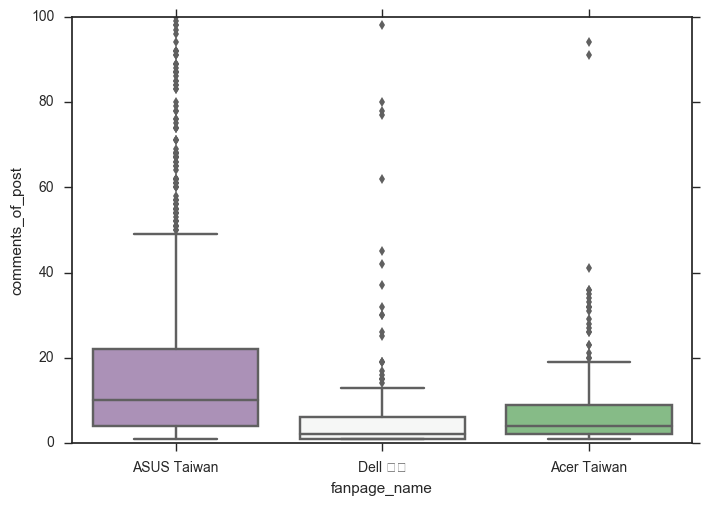

In [8]:
def showSeabornBoxplot(df, x, y, lower_bound, upper_bound):
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.set(style= 'ticks')
    sns_plot = sns.boxplot(x= x, y= y, data= df, palette= 'PRGn')
    fig = sns_plot.get_figure()
    plt.ylim(lower_bound, upper_bound)

showSeabornBoxplot(df, 'fanpage_name', 'comments_of_post', 0, 100)

In [9]:
from bokeh.charts import BoxPlot, output_file, show
from bokeh.io import output_notebook
output_notebook()
show(BoxPlot(df, values= 'comments_of_post', label= 'fanpage_name', color= 'fanpage_name',
             title= '3個粉絲頁中每個post的comments數量箱型圖 (有outliers)'))

Loading BokehJS ...

In [10]:
qsearch = \
{
  "query": {
    "terms": {
      "fname": chosen_fanpage
    }
  },
  "size": 0,
  "aggs": {
    "fname": {
      "terms": {
        "field": "fname"
      },
      "aggs": {
        "shares_count": {
          "terms": {
            "field": "shares.count",
            "size": 0
          }
        }
      }
    }
  }
}

result = conn.search_raw(query= qsearch, indices= 'facebook_nested', doc_types= 'post')

df = []
for fanpage in result['aggregations']['fname']['buckets']:
    row = {}
    row['fanpage_name'] = fanpage['key']
    row['number_of_posts'] = fanpage['doc_count']
    row['posts_be_shared'] = 0
    for shares_count in fanpage['shares_count']['buckets']:
        if shares_count['key'] != 0:
            row['posts_be_shared'] += shares_count['doc_count']
    df.append(row)

for i in df:
    i['ratio of post with sharing'] = '%.1f%%' % (i['posts_be_shared'] / i['number_of_posts'] * 100)
df = pd.DataFrame(df)
df

,fanpage_name,number_of_posts,posts_be_shared,ratio of post with sharing
0,ASUS Taiwan,2248,2160,96.1%
1,Dell 台灣,749,492,65.7%
2,Acer Taiwan,453,401,88.5%


,comments_per_month(mean),comments_per_month(min),comments_per_month(max)
fanpage_name,,,
ASUS Taiwan,3739.390244,254,13590
Acer Taiwan,297.585366,2,3656
Dell 台灣,445.902439,0,2257


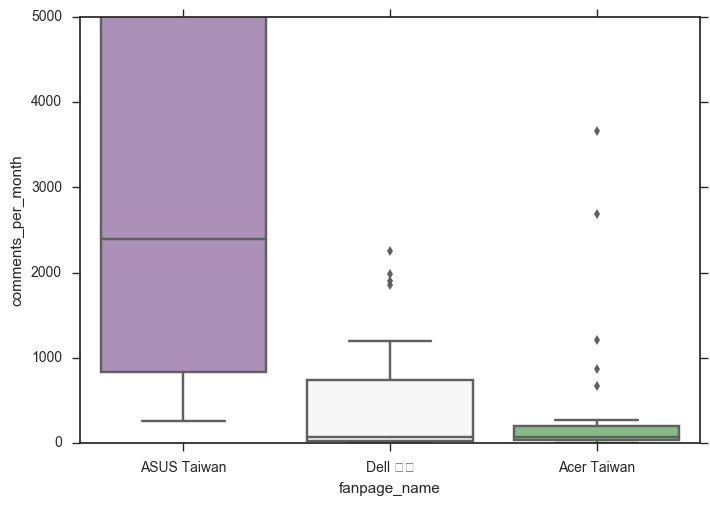

In [11]:
qsearch = \
{
  "query": {
    "terms": {
      "fname": chosen_fanpage
    }
  },
  "size": 0,
  "aggs": {
    "fname": {
      "terms": {
        "field": "fname",
        "size": 0
      },
      "aggs": {
        "comments_per_month": {
          "date_histogram": {
            "field": "created_time",
            "interval": "month",
            "format": "yyyy-MM"
          }
        }
      }
    }
  }
}

result = conn.search_raw(query= qsearch, indices= 'facebook_nested', doc_types= 'comment')

df = []
for fanpage in result['aggregations']['fname']['buckets']:
    for comments_per_month in fanpage['comments_per_month']['buckets']:
        row = {}
        row['fanpage_name'] = fanpage['key']
        row['date'] = comments_per_month['key_as_string']
        row['comments_per_month'] = comments_per_month['doc_count']
        df.append(row)

df = pd.DataFrame(df)
showSeabornBoxplot(df, 'fanpage_name', 'comments_per_month', 0, 5000)
df.groupby('fanpage_name')['comments_per_month'].agg({'comments_per_month(min)': min,
                                                      'comments_per_month(max)': max,
                                                      'comments_per_month(mean)': 'mean'})

In [12]:
qsearch = \
{
  "query": {
    "terms": {
      "fname": chosen_fanpage
    }
  },
  "size": 0,
  "aggs": {
    "fname": {
      "terms": {
        "field": "fname",
        "size": 0
      },
      "aggs": {
        "posts_per_month": {
          "date_histogram": {
            "field": "created_time",
            "interval": "month",
            "format": "yyyy-MM"
          },
          "aggs": {
            "sum_of_like": {
              "sum": {
                "field": "likes_count"
              }
            }
          }
        }
      }
    }
  }
}

result = conn.search_raw(query= qsearch, indices= 'facebook_nested', doc_types= 'post')

df = []
for fanpage in result['aggregations']['fname']['buckets']:
    for posts_per_month in fanpage['posts_per_month']['buckets']:
        row = {}
        row['fanpage_name'] = fanpage['key']
        row['date'] = posts_per_month['key_as_string']
        row['likes_of_posts_per_month'] = int(posts_per_month['sum_of_like']['value'])
        df.append(row)

df = pd.DataFrame(df)
df.groupby('fanpage_name')['likes_of_posts_per_month'].agg({'likes_of_posts_per_month(min)': min,
                                                      'likes_of_posts_per_month(max)': max,
                                                      'likes_of_posts_per_month(mean)': 'mean'})

,likes_of_posts_per_month(min),likes_of_posts_per_month(max),likes_of_posts_per_month(mean)
fanpage_name,,,
ASUS Taiwan,5588,143559,35632.292683
Acer Taiwan,31,47568,5466.829268
Dell 台灣,0,16984,2353.463415


In [22]:
qsearch = \
{
  "query": {
    "terms": {
      "fname": chosen_fanpage
    }
  },
  "size": 0,
  "aggs": {
    "fname": {
      "terms": {
        "field": "fname",
        "size": 0
      },
      "aggs": {
        "from_id": {
          "terms": {
            "field": "from.id",
            "size": 1
          }
        }
      }
    }
  }
}

result = conn.search_raw(query= qsearch, indices= 'facebook_nested', doc_types= 'comment')

for fanpage in result['aggregations']['fname']['buckets']:
    print(fanpage['key'] + '\tcomment from unique user: ' + str(fanpage['doc_count']))

ASUS Taiwan	comment from unique user: 153315
Dell 台灣	comment from unique user: 18282
Acer Taiwan	comment from unique user: 12201


In [21]:
%matplotlib inline

def userCommentOnPostFreqMatrix(addr, row, column, fname):
    import pyes
    conn = pyes.ES(addr)
    
    tagg = pyes.aggs.TermsAgg(row, field= row, sub_aggs= [], size= 10)
    tagg1 = pyes.aggs.TermsAgg(column, field= column, min_doc_count= 1, size= 10)
    tagg.sub_aggs.append(tagg1)
    
    tq = pyes.query.TermQuery(field = 'fname', value= fname)
    qsearch = pyes.query.Search(tq, size= 0) ### "size" 0 for "hits" not showing
    qsearch.agg.add(tagg)
    rs = conn.search(query= qsearch, indices= 'facebook_nested', doc_types= 'comment')

    rowIndexList, colIndexList, matrix = [], [], []
    rowcount, colcount = 0, 0
    for user in rs.aggs[row]['buckets']:
        rowIndexList.append(user['key'])
        rowcount = rowcount + 1
        for post in user[column]['buckets']:
            if post['key'] not in colIndexList:
                colIndexList.append(post['key'])
                colcount = colcount + 1

    for i in range(0, len(rowIndexList)):
        matrix.append([0.0] * len(colIndexList))

    for user in rs.aggs[row]['buckets']:
        for post in user[column]['buckets']:
            matrix[rowIndexList.index(user['key'])][colIndexList.index(post['key'])] = float(post['doc_count'])

    return {'data': matrix, 'col': colIndexList, 'row': rowIndexList}

def corrHeatmap(matrix, col):
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.set(style= 'white')

    d = pd.DataFrame(data= matrix['data'],
                     columns= matrix[col])

    # Compute the correlation matrix
    corr = d.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype= np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize= (20, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap= True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask= mask, cmap= cmap, vmax= .3,
                square= True, xticklabels= 5, yticklabels= 5,
                linewidths= .5, cbar_kws= {'shrink': .5}, ax= ax)

def transpose(matrix):
    return [list(i) for i in zip(*matrix)]

def mT(matrix):
    a = matrix.copy()
    a['data'] = transpose(a['data'])
    return a

In [23]:
addr = '127.0.0.1:9200'
row = 'from.id'
column = 'fid_pid'
fname = 'Dell 台灣'
matrix = userCommentOnPostFreqMatrix(addr, row, column, fname) ### JVM記憶體太小容易失敗？

pyes object <pyes.es.ES object at 0x000002900EC7F0F0> is being destroyed, but bulk operations have not been flushed. Call force_bulk()!


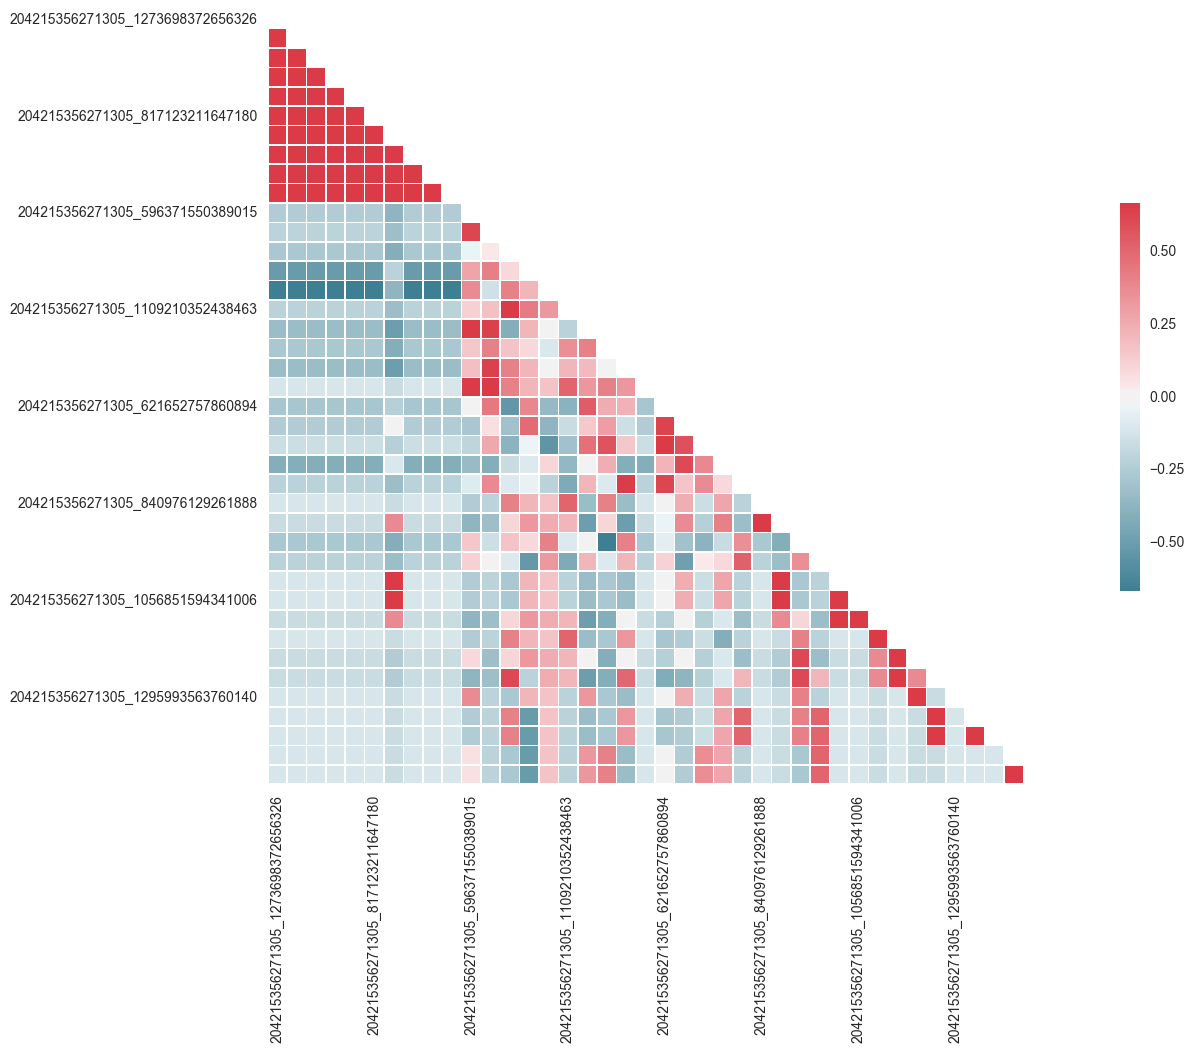

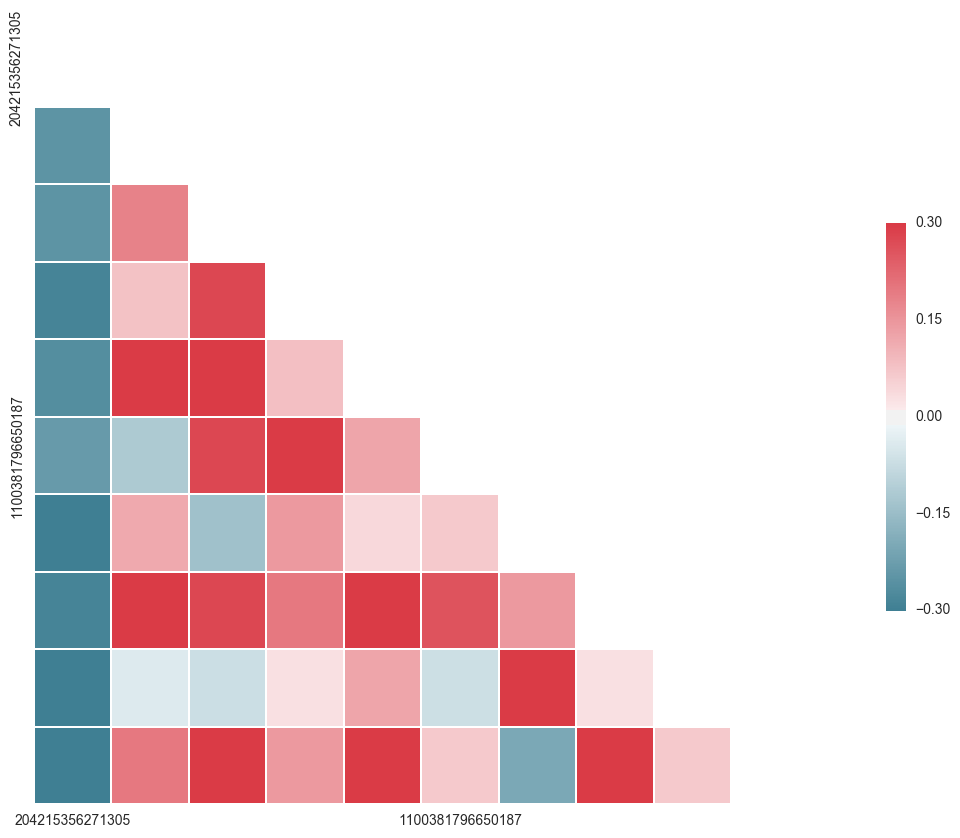

In [24]:
corrHeatmap(matrix, 'col') ### posts
corrHeatmap(mT(matrix), 'row') ### users

In [25]:
def drawBipartiteGraph(matrix, with_labels):
    import networkx as nx
    import numpy as np
    import matplotlib.pyplot as plt

    g = nx.Graph()
    g.add_nodes_from(matrix['row'], bipartite= 0)
    g.add_nodes_from(matrix['col'], bipartite= 1)
    for i in range(len(matrix['data'])):
        for j in range(len(matrix['data'][i])):
            if matrix['data'][i][j] != 0:
                g.add_edge(matrix['row'][i], matrix['col'][j], weight= matrix['data'][i][j])

    # Separate by group
    l, r = nx.bipartite.sets(g)
    pos = {}

    # Update position for node from each group
    pos.update((node, (1, index)) for index, node in enumerate(l))
    pos.update((node, (2, index)) for index, node in enumerate(r))

    nx.draw(g, pos= pos, edge_color= np.random.random(g.number_of_edges()), with_labels= with_labels)
    plt.show()

def drawBipartiteNXGraph(matrix, with_labels):
    import networkx as nx
    import matplotlib.pyplot as plt

    g = nx.Graph()
    g.add_nodes_from(matrix['row'], bipartite= 0)
    g.add_nodes_from(matrix['col'], bipartite= 1)
    for i in range(len(matrix['data'])):
        for j in range(len(matrix['data'][i])):
            if matrix['data'][i][j] != 0:
                g.add_edge(matrix['row'][i], matrix['col'][j], weight= matrix['data'][i][j])

    # Separate by group
    l, r = nx.bipartite.sets(g)
    pos = {}

    # Update position for node from each group
    pos.update((node, (1, index)) for index, node in enumerate(l))
    pos.update((node, (2, index)) for index, node in enumerate(r))

    nx.draw_networkx(g, with_labels= with_labels)#node_color= 
    plt.show()

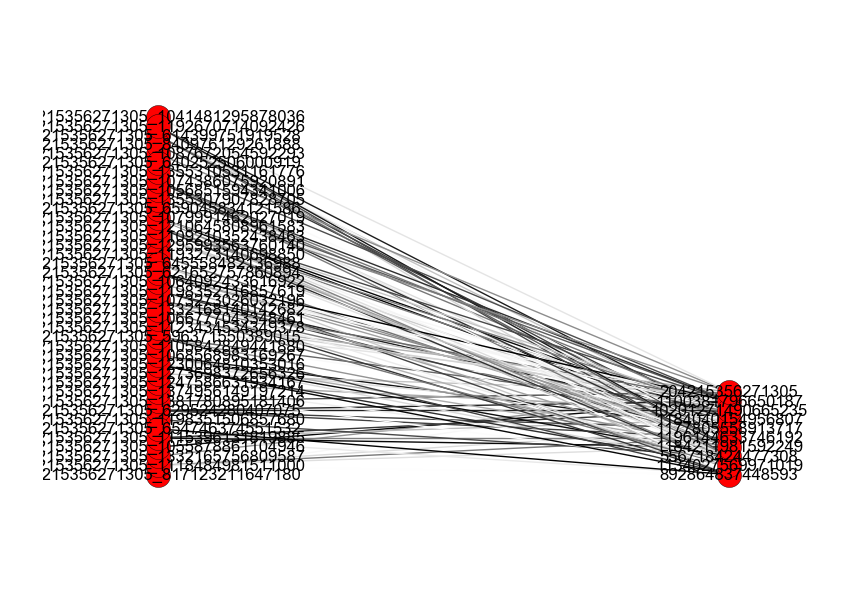

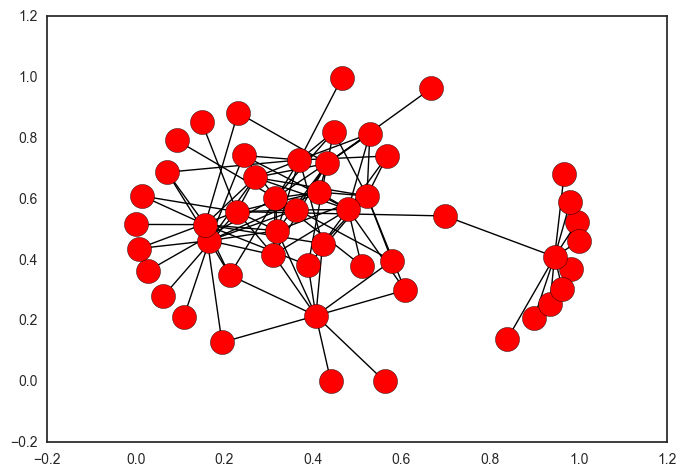

In [26]:
drawBipartiteGraph(matrix, True) ### users and posts
drawBipartiteNXGraph(matrix, False) ### users and posts

pyes object <pyes.es.ES object at 0x0000029009DD3E80> is being destroyed, but bulk operations have not been flushed. Call force_bulk()!


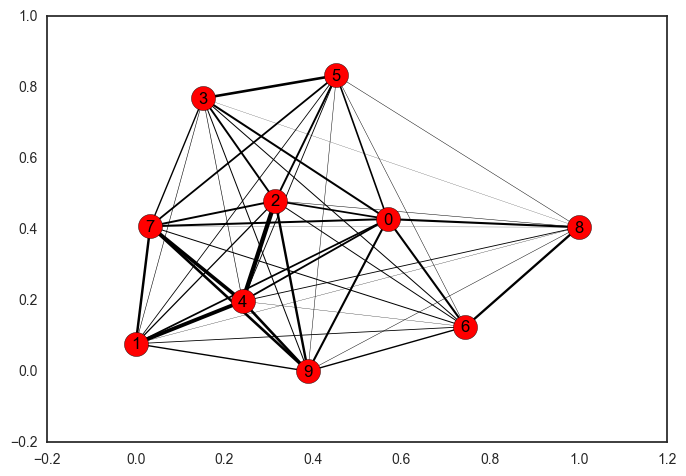

In [27]:
def drawGraph(adjMatrix):
    import networkx as nx
    import matplotlib.pyplot as plt

    g = nx.Graph()
    for i in range(len(adjMatrix)):
        for j in range(i + 1, len(adjMatrix)):
            g.add_edge(i, j, weight= abs(adjMatrix[i][j]))

    weights = [e['weight'] * 5 for f, t, e in g.edges(data=True)]
    nx.draw_networkx(g, width= weights)
    plt.show()

import pandas as pd
corr = pd.DataFrame(data= matrix['data'], columns= matrix['col']).transpose().corr()
drawGraph(corr) ### users to users

In [28]:
corr

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.250821,-0.250635,-0.286624,-0.263626,-0.233723,-0.300501,-0.286624,-0.300501,-0.300501
1,-0.250821,1.000000,0.182329,0.079268,0.552924,-0.119239,0.119239,0.354985,-0.039746,0.198732
2,-0.250635,0.182329,1.000000,0.277234,0.627179,0.278019,-0.139010,0.277234,-0.069505,0.347524
3,-0.286624,0.079268,0.277234,1.000000,0.083315,0.375748,0.144518,0.197995,0.028904,0.144518
4,-0.263626,0.552924,0.627179,0.083315,1.000000,0.125327,0.041776,0.518004,0.125327,0.375980
5,-0.233723,-0.119239,0.278019,0.375748,0.125327,1.000000,0.066667,0.260133,-0.066667,0.066667
6,-0.300501,0.119239,-0.139010,0.144518,0.041776,0.066667,1.000000,0.144518,0.333333,-0.200000
7,-0.286624,0.354985,0.277234,0.197995,0.518004,0.260133,0.144518,1.000000,0.028904,0.375748
8,-0.300501,-0.039746,-0.069505,0.028904,0.125327,-0.066667,0.333333,0.028904,1.000000,0.066667
9,-0.300501,0.198732,0.347524,0.144518,0.375980,0.066667,-0.200000,0.375748,0.066667,1.000000
